In [1]:
import pandas as pd
import geopandas as gpd
import contextily as cx
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
from shapely.geometry import Point, LineString, MultiLineString
geojson = 'GeoJSON'

In [2]:
mesh = gpd.read_file('../data/2019/mesh500/HDDSWH5339/MESH05339.shp', crs=4612).to_crs(2451)

In [3]:
kokusei = pd.DataFrame()
for x in mesh.MESH1_ID.unique():
    kokusei = pd.concat([kokusei,
        pd.read_csv(f"../data/2019/kokutyou500/tblT000847H{x}.txt", encoding='sjis', skiprows=[1])])
kokusei = kokusei[['KEY_CODE', 'T000847001']]
kokusei.columns = ['KEY_CODE', 'people']
kokusei.KEY_CODE = kokusei.KEY_CODE.astype(str)
kokusei = pd.merge(mesh[['KEY_CODE', 'geometry']], kokusei, on='KEY_CODE')
kokusei['area_t'] = kokusei.area

In [4]:
keizai = pd.DataFrame()
for x in mesh.MESH1_ID.unique():
    keizai = pd.concat([keizai,
        pd.read_csv(f"../data/2019/keizai500/tblT000389H{x}.txt", encoding='sjis', skiprows=[1])])
keizai.columns = ['KEY_CODE', 'company', 'people']
keizai.KEY_CODE = keizai.KEY_CODE.astype(str)
keizai = pd.merge(mesh, keizai, on='KEY_CODE')
keizai['area_t'] = keizai.area

In [5]:
stations = gpd.read_file('../data/railway/ekidata.geojson', crs=4326).to_crs(2451)

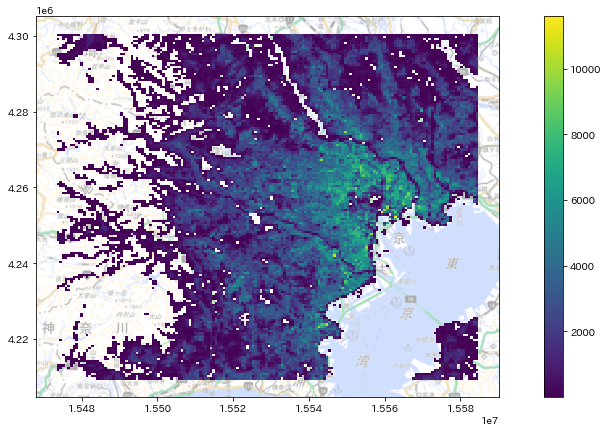

In [6]:
ax = kokusei.to_crs(3857).plot('people', legend=True, figsize=(16, 7))
cx.add_basemap(ax, source='https://cyberjapandata.gsi.go.jp/xyz/pale/{z}/{x}/{y}.png', alpha=0.7)

In [18]:
tokyoeki = stations[stations.station_name.str.contains('東京')].geometry.values[0]

In [68]:
x = stations[stations.line_cd.isin([11312, 11315, 11316])].copy()
x.geometry = stations.geometry.buffer(1000)
x = gpd.overlay(kokusei, x)
x['ans'] = x.people * (x.area / x.area_t)
x = x.groupby('station_cd').sum().reset_index()[['station_cd', 'ans']]
po = pd.merge(stations, x, on='station_cd')
po = po.drop_duplicates(subset='station_g_cd')
po = po.sort_values(['station_cd', 'e_sort'])
po = po.iloc[5:, :]
po.ans = round(po.ans).astype(int)
po['tokyo'] = round(po.geometry.distance(tokyoeki), -3).astype(int)

In [50]:
x = gpd.overlay(keizai, gpd.GeoDataFrame([None], geometry=[tokyoeki.buffer(10000)], crs=2451))
tokyo_syugyo = x.people.sum()
ans = []
for n in range(10000, 65000, 1000):
    x = gpd.overlay(keizai, gpd.GeoDataFrame([None], geometry=[tokyoeki.buffer(n)], crs=2451))
    x = tokyo_syugyo / x.people.sum()
    ans.append([n, round(x * 100)])
syugyo_buffer = pd.DataFrame(ans)

In [69]:
syugyo_buffer.columns = ['tokyo', 'syugyo'] 
x = syugyo_buffer.copy()
x.syugyo = x.syugyo - 30
po2 = pd.merge(po, x, on='tokyo', how='left')

In [75]:
po2.syugyo = po2.syugyo.fillna(70)
po2['genjitsu'] = po2.ans * 0.5 * (po2.syugyo / 100)

In [81]:
(po2.genjitsu.sum() * 0.3 / 28 ) / 1582

1.319513319487087

In [111]:
x = stations[stations.line_cd.isin([11312, 11315, 11316])].copy()
x.geometry = stations.geometry.buffer(2000)
x = gpd.overlay(kokusei, x)
x['p2000'] = x.people * (x.area / x.area_t)
x = x.groupby('station_cd').sum().reset_index()[['station_cd', 'p2000']]
po3 = pd.merge(po2, x, on='station_cd')

In [98]:
po3[['station_cd', 'station_name']].to_csv('output/t.csv', index=None)

In [112]:
x = pd.read_csv('output/t.csv').drop('station_name', 1)
x = pd.merge(po3, x, on='station_cd').iloc[:, 2:].drop(['line_name_h', 'station_g_cd', 'e_sort'], 1)
x.p2000 = x.p2000.astype(int)
x.drop('p2000r', 1)
x['g2'] = x.genjitsu.mask(x.f1 == 1, (x.p2000 - x.ans) * 0.5 * ((x.syugyo - 10) / 100)).astype(int)
print('混雑率 :', (x.g2.sum() * 0.3 / 28 ) / 1582)

混雑率 : 1.880980223947986
